# Directly Calculating ∆F From Data
© 2018 Griffin Chure. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

--- 

In [1]:
import sys
sys.path.insert(0, '../../')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mut.thermo
import mut.viz
constants = mut.thermo.load_constants()
mut.viz.plotting_style()
colors = mut.viz.color_selector('mut')
pboc = mut.viz.color_selector('pboc')

In this notebook, we explore how well the data is described by our formulation of $\Delta F$ for the Razo-Mejia 2018 data as well as our mutants from this work. 

In [9]:
# Load data from Razo Mejia 2018
ind_data = pd.read_csv('../../data/csv/RazoMejia2018_data.csv')
ind_data.rename(columns={'fold_change_A':'fold_change', 'IPTG_uM':'IPTGuM'}, inplace=True)
ind_data['repressors'] *= 2
ind_data = ind_data[(ind_data['repressors'] > 0) & (ind_data['operator']!='Oid')].copy()

# Load data from this work
data = pd.read_csv('../../data/csv/compiled_data.csv')
data.dropna(inplace=True)

# Restrict data set to only the mutants
data = data[data['class'] != 'WT']

## Testing Collapse from Razo-Mejia 2018

In [80]:
# Compute the empirical bohr. 
ind_data['empirical_F'] = np.log((1 / ind_data['fold_change']) - 1)

# Compute relative to the Oid sequence. 
ind_data['allc_ref']= -mut.thermo.SimpleRepression(R=ind_data['repressors'], ep_r=-17,
                                     ka=constants['Ka'], ki=constants['Ki'], ep_ai=constants['ep_AI'],
                                     n_sites=constants['n_sites'], effector_conc=ind_data['IPTGuM']).bohr_parameter()
ind_data['ec50_ref'] = -mut.thermo.SimpleRepression(R=ind_data['repressors'], ep_r=-17,
                                     ka=constants['Ka'], ki=constants['Ki'], ep_ai=constants['ep_AI'],
                                     n_sites=constants['n_sites'], effector_conc=50).bohr_parameter()

# Compute the empirical ∆F. 
ind_data['allc_delta_F'] = ind_data['allc_ref'] - ind_data['empirical_F']
ind_data['ec50_delta_F'] = ind_data['ec50_ref'] - ind_data['empirical_F']

# Identify the "valid" concentrations in which no measurements are below 0 or above 1
ind_data['nonphysical'] = (ind_data['fold_change'] <=0) + (ind_data['fold_change'] >= 1)
ind_grouped = ind_data.groupby(['IPTGuM', 'repressors', 'operator']).agg(('mean', 'sem')).reset_index()
ind_grouped['valid'] = 0
ind_grouped.loc[grouped['nonphysical']['mean'] == 0, 'valid'] = 1

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  
/anaconda3/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


With all of that grouped, let's look at the ∆F collapse as a function of $c$ for all operators.  

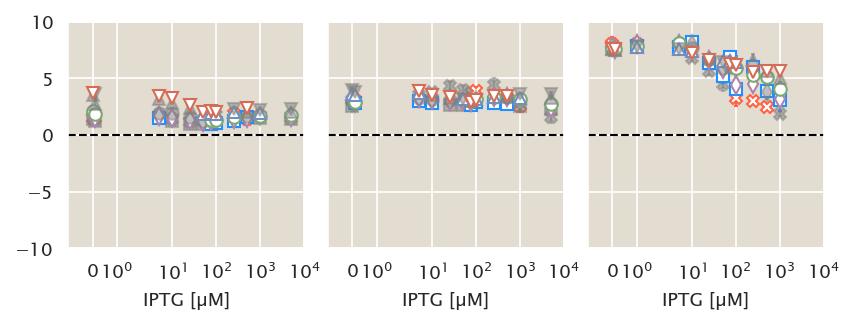

In [81]:
glyphs = {22:'X', 60:'s', 124:'d', 260:'o', 1220:'^', 1740:'v'}

fig, ax = plt.subplots(1, 3, figsize=(6.5, 2), dpi=150,
                      sharey=True, sharex=True)

rep_colors = {r:c for r, c  in zip(ind_data['repressors'].unique(), [pboc['red'], pboc['blue'], pboc['green'], pboc['purple'], 'dodgerblue', 'tomato'])}
# Define the axes per operator. 
axes = {'O1': ax[0], 'O2': ax[1], 'O3':ax[2]}

for g, d in ind_grouped.groupby(['operator', 'repressors', 'valid']):
    if g[-1] == 0:
        color='gray'
        alpha=0.5
        facecolor='gray'
    else:
        color=rep_colors[g[1]]
        facecolor='w'
        alpha=1
    
    # Plot the data. 
    _ = axes[g[0]].errorbar(d['IPTGuM'], d['allc_delta_F']['mean'], d['allc_delta_F']['sem'],
                           marker=glyphs[g[1]], color=color, markerfacecolor=facecolor, lw=1, 
                           linestyle='none', capsize=1, alpha=alpha)
    

# Formatting for the plot
for a in ax:
    a.hlines(0, -1, 1E4, linestyle='--', color='k', 
             label='__nolegend__', linewidth=1)
    a.xaxis.set_tick_params(labelsize=9)
    a.yaxis.set_tick_params(labelsize=9)
    a.set_xscale('symlog')
    a.set_xlim([-1, 1E4])
    a.set_xlabel('IPTG [µM]', fontsize=9)
    a.set_ylim([-10, 10])
plt.subplots_adjust(wspace=0.1)

# Mutant Data

In [82]:

# Mark measurements beyond bounds. 
data['nonphysical'] = (data['fold_change'] <=0) + (data['fold_change'] >= 1)

# Calculate the empirical bohr. 
data['empirical_F'] = np.log((1 / data['fold_change']) - 1)

# Insert the wt bohr parameter. 
epr = [constants[op] for op in data['operator']]
wt_bohr = -mut.thermo.SimpleRepression(R=data['repressors'], ep_r=epr,
                                     ep_ai=constants['ep_AI'], ka=constants['Ka'],
                                     ki=constants['Ki'], n_sites=constants['n_sites'],
                                     effector_conc=data['IPTGuM']).bohr_parameter()
data['wt_bohr'] = wt_bohr

# Compute the empirical Delta F
data['delta_F'] = data['wt_bohr'] - data['empirical_F']

# Group by IPTG and compute means and sem.
grouped = data.groupby(['class', 'IPTGuM', 'mutant', 'repressors', 'operator']).agg(('mean', 'sem')).reset_index()
grouped['valid'] = 0
grouped.loc[grouped['nonphysical']['mean'] == 0, 'valid'] = 1

/anaconda3/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


# Separating by mutant

In [83]:
# Load the DNA mutant sampling statistics
stats = pd.read_csv('../../data/csv/DNA_binding_energy_summary.csv')
stats.drop_duplicates(inplace=True)

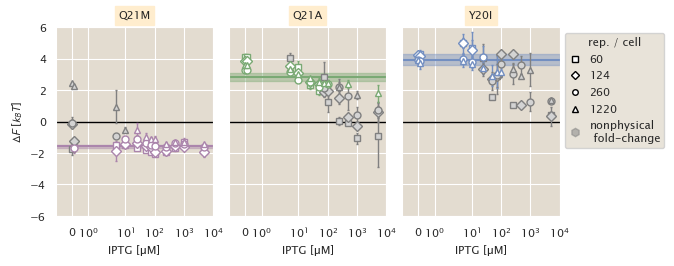

In [84]:
glyphs = {60:'s', 124:'D', 260:'o', 1220:'^'}
fig, ax = plt.subplots(1, 3, figsize=(6.5, 2.5), dpi=100, sharey=True)
axes = {'Q21M':ax[0], 'Q21A':ax[1], 'Y20I':ax[2]}
for g, d in grouped[(grouped['class']=='DNA') & (grouped['operator']=='O2')].groupby(['mutant', 'repressors', 'valid']):
    if g[-1] == 0:
        fc='lightgray'
        color='gray'
        label='__nolegend__'
    else:
        fc='w'
        color=colors[g[0]]
        label=int(g[1])

    
    _ = axes[g[0]].errorbar(d['IPTGuM'], d['delta_F']['mean'], d['delta_F']['sem'], linestyle='',
                            markersize=5, color=color, fmt=glyphs[g[1]],
                            lw=1, capsize=1, markerfacecolor=fc, label='__nolegend__', zorder=2)

for mu, _ax in axes.items():  
    # Plot the credible regions. 
    _stats = stats[(stats['parameter']=='ep_RA') &
                                   (stats['repressors']==260) &
                                   (stats['operator']=='O2') & 
                                   (stats['mutant']==mu)]
    mode = _stats['mode'].values[0]
    min_val = _stats['hpd_min'].values[0]
    max_val = _stats['hpd_max'].values[0]
    _ax.hlines(-(-13.9 - mode), -1, 1E4, color=colors[mu], zorder=1)
    _ax.fill_between(np.linspace(-1, 1E4, 300), -(-13.9-max_val), -(-13.9-min_val), color=colors[mu], alpha=0.4, zorder=1)
    _ax.set_title(f'{mu}', backgroundcolor=pboc['pale_yellow'], fontsize=8) 
    
for a in ax:
    a.set_xscale('symlog')
    a.set_ylim([-6, 6])
    a.hlines(0, -1, 1E4, linestyle='-', label='__nolegend__', zorder=1, lw=1)
    a.set_xlim([-1, 1E4])
    a.xaxis.set_tick_params(labelsize=8)
    a.yaxis.set_tick_params(labelsize=8)
    a.set_xlabel('IPTG [µM]', fontsize=8)
ax[0].set_ylabel('$\Delta F$ [$k_BT$]', fontsize=8) 

# Add complicated legend entries
for r, g in glyphs.items():
    ax[2].plot([], [], marker=g, linestyle='none', label=int(r), color='k', 
              markerfacecolor='w', markersize=4)
ax[2].plot([], [], 'h', linestyle='none', color='gray', alpha=0.5, label='nonphysical\n fold-change')
_ = ax[2].legend(fontsize=8, title='rep. / cell', ncol=1, bbox_to_anchor=(1, 1), handlelength=1)
_.get_title().set_fontsize(8)
plt.subplots_adjust(wspace=0.1)

plt.savefig('../../figures/DNA_delta_F.pdf', bbox_inches='tight')

## Inducer binding mutants.

In [45]:
# Load the DNA mutant sampling statistics
kaki_only_stats = pd.read_csv('../../data/csv/KaKi_only_summary.csv')
kaki_only_stats = kaki_only_stats[kaki_only_stats['operator']=='O2'].copy()
kaki_only_samples = pd.read_csv('../../data/csv/KaKi_only_samples.csv')
kaki_only_samples = kaki_only_samples[kaki_only_samples['operator']=='O2'].copy()
kaki_epAI_stats = pd.read_csv('../../data/csv/KaKi_epAI_summary.csv')
kaki_epAI_stats = kaki_epAI_stats[kaki_epAI_stats['operator']=='O2'].copy()
kaki_epAI_samples = pd.read_csv('../../data/csv/KaKi_epAI_samples.csv')
kaki_epAI_samples = kaki_epAI_samples[kaki_epAI_samples['operator']=='O2'].copy()

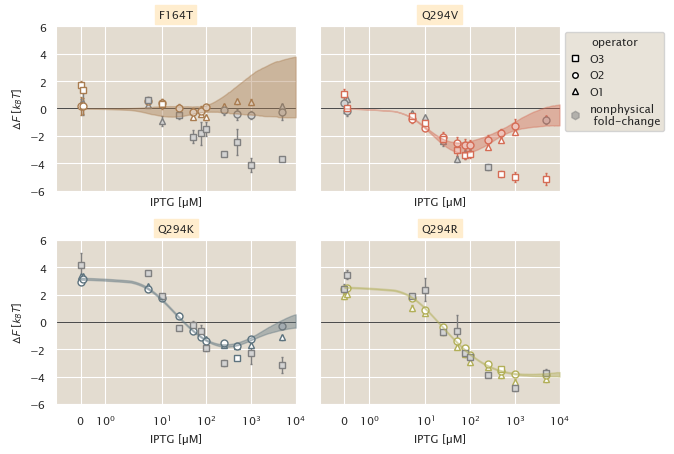

In [44]:
glyphs = {'O3':'s',  'O2':'o', 'O1':'^'}
fig, ax = plt.subplots(2, 2, figsize=(6.5, 5), dpi=100, sharey=True, sharex=True)
axes = {'F164T':ax[0, 0], 'Q294V':ax[0, 1], 'Q294K':ax[1, 0], 'Q294R':ax[1, 1]}
for g, d in grouped[(grouped['class']=='IND')].groupby(['mutant', 'operator', 'valid']):
    if g[-1] == 0:
        fc='lightgray'
        color='gray'
    else:
        fc='w'
        color=colors[g[0]]
    
    _ = axes[g[0]].errorbar(d['IPTGuM'], d['delta_F']['mean'], d['delta_F']['sem'], linestyle='',
                            markersize=5, color=color, fmt=glyphs[g[1]],
                            lw=1, capsize=1, markerfacecolor=fc, label='__nolegend__', zorder=2)

# Plot the fits adn credible regions. 
c_range = np.logspace(-2, 4, 200)
c_range[0] = 0
wt_pact = mut.thermo.MWC(effector_conc=c_range, ka=constants['Ka'], ki=constants['Ki'],
                        ep_ai=constants['ep_AI'], n_sites=constants['n_sites']).pact()

# Plot cred regions for samples without biophysical epistasis. 
for m in ['F164T', 'Q294V']:
    # Isolate the samples. 
    _samples = kaki_only_samples[kaki_only_samples['mutant']==m]
    # Compute the credible regions. 
    cred_region = np.zeros((2, len(c_range)))
    for i, c in enumerate(c_range):
        mut_pact = mut.thermo.MWC(effector_conc=c, ka=_samples['Ka'], ki=_samples['Ki'],
                                 ep_ai=constants['ep_AI'], n_sites=constants['n_sites']).pact()
        deltaF = np.log(wt_pact[i]) - np.log(mut_pact)
        cred_region[:, i] = mut.stats.compute_hpd(deltaF, 0.95)
    
    # Plot the credible regions. 
    axes[m].fill_between(c_range, cred_region[0, :], cred_region[1, :],
                        color=colors[m], alpha=0.4, zorder=100)
    axes[m].set_title(f'{m}', backgroundcolor=pboc['pale_yellow'], fontsize=8) 
    
for m in ['Q294R', 'Q294K']:
    # Isolate the samples. 
    _samples = kaki_epAI_samples[kaki_epAI_samples['mutant']==m]
    # Compute the credible regions. 
    cred_region = np.zeros((2, len(c_range)))
    for i, c in enumerate(c_range):
        mut_pact = mut.thermo.MWC(effector_conc=c, ka=_samples['Ka'], ki=_samples['Ki'],
                                 ep_ai=_samples['ep_AI'], n_sites=constants['n_sites']).pact()
        deltaF = np.log(wt_pact[i]) - np.log(mut_pact)
        cred_region[:, i] = mut.stats.compute_hpd(deltaF, 0.95)
    
    # Plot the credible regions. 
    axes[m].fill_between(c_range, cred_region[0, :], cred_region[1, :],
                        color=colors[m], alpha=0.4, zorder=100)       
    axes[m].set_title(f'{m}', backgroundcolor=pboc['pale_yellow'], fontsize=8) 
    
for a in ax.ravel():
    a.set_xscale('symlog')
    a.set_ylim([-6, 6])
    a.hlines(0, -1, 1E4, linestyle='-', label='__nolegend__', zorder=1, lw=0.5)
    a.set_xlim([-1, 1E4])
    a.xaxis.set_tick_params(labelsize=8)
    a.yaxis.set_tick_params(labelsize=8)
    a.set_xlabel('IPTG [µM]', fontsize=8)
    
for i in range(2):
    ax[i, 0].set_ylabel('$\Delta F$ [$k_BT$]', fontsize=8) 

# Add complicated legend entries
for r, g in glyphs.items():
    ax[0, 1].plot([], [], marker=g, linestyle='none', label=r, color='k', 
              markerfacecolor='w', markersize=4)
ax[0, 1].plot([], [], 'h', linestyle='none', color='gray', alpha=0.5, label='nonphysical\n fold-change')
_ = ax[0, 1].legend(fontsize=8, title='operator', ncol=1, bbox_to_anchor=(1, 1), handlelength=1)
_.get_title().set_fontsize(8)
plt.subplots_adjust(wspace=0.1, hspace=0.3)

plt.savefig('../../figures/IND_delta_F.pdf', bbox_inches='tight')



## Double Mutants

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


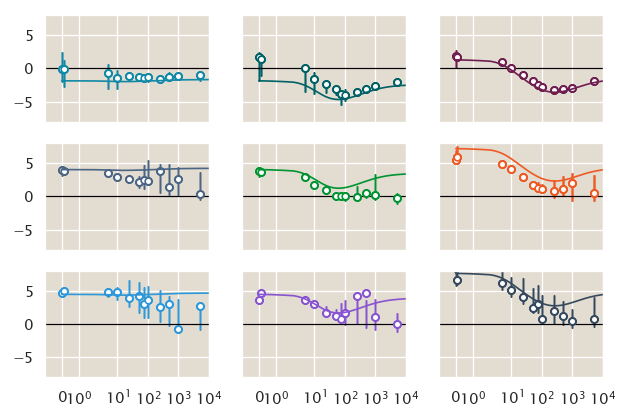

In [96]:
DNA_idx = {'Q21M':0, 'Q21A':1, 'Y20I':2}
IND_idx = {'F164T':0, 'Q294V':1, 'Q294K':2}

fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, dpi=120)
# Plot only the modes for right now...
DBL = emp_stats[emp_stats['class']=='DBL']
DBL['valid'] = 1
for g, d in DBL.groupby(['mutant', 'valid']):
    dna, ind = g[0].split('-')
    _ax = ax[DNA_idx[dna], IND_idx[ind]]
    if g[-1] == 1:
        color=colors[g[0]]
        facecolor='w'
    else:
        color='gray'
        facecolor='lightgray'
    
    _ax.plot(d['IPTGuM'], d['delta_F_mode'], marker='o', lw=0, 
                markerfacecolor=facecolor, color=color, ms=4)
    _ax.vlines(d['IPTGuM'], d['delta_F_max'], d['delta_F_min'], color=color, lw=0.75)
  
c_range = np.logspace(-2, 4, 500)
c_range[0] = 0
wt_bohr = -mut.thermo.SimpleRepression(R=260, ep_r=-13.9, ka=constants['Ka'], 
                                       ki=constants['Ki'], ep_ai=constants['ep_AI'], 
                                       effector_conc=c_range).bohr_parameter()

for dna in DNA_idx.keys():
    for ind in IND_idx.keys():
        _ax = ax[DNA_idx[dna], IND_idx[ind]]
        if ind == 'Q294K':
            epAI = kaki_epAI_stats[(kaki_epAI_stats['parameter']=='ep_AI') &
                                  (kaki_epAI_stats['mutant']==ind)]['mode'].values[0]
            _kaki_stats = kaki_epAI_stats
        else:
            epAI = 4.5
            _kaki_stats = kaki_only_stats
        ep_RA = stats[(stats['parameter']=='ep_RA') & (stats['mutant']==dna)]['mode'].values[0]
        ka = _kaki_stats[(_kaki_stats['parameter']=='Ka') &
                        (_kaki_stats['mutant']==ind)]['mode'].values[0]
        ki = _kaki_stats[(_kaki_stats['parameter']=='Ki') & 
                        (_kaki_stats['mutant']==ind)]['mode'].values[0]
        mut_bohr = -mut.thermo.SimpleRepression(R=260, ep_r=ep_RA, ka=ka, ki=ki, ep_ai=epAI,
                                               effector_conc=c_range).bohr_parameter()
        delta = wt_bohr - mut_bohr
        _ax.plot(c_range, delta, color=colors[f'{dna}-{ind}'], lw=1)
    
for a in ax.ravel():
    a.xaxis.set_tick_params(labelsize=9)
    a.yaxis.set_tick_params(labelsize=9)
    a.set_xscale('symlog')
    a.set_xlim([-1, 1E4])
    a.set_ylim([-8, 8])
    a.hlines(0, -1, 1E4, color='k', lw=0.75)


In [88]:
d

,fc_mode,fc_min,fc_max,bohr_mode,bohr_min,bohr_max,mutant,IPTGuM,repressors,operator,class,valid
589,0.457802,0.263114,0.482956,0.169194,0.057802,1.016689,Q21A-F164T,0.0,260.0,O2,DBL,1
594,0.435567,0.340644,0.530771,0.259171,-0.123240,0.660425,Q21A-F164T,0.1,260.0,O2,DBL,1
599,0.522972,0.425965,0.577159,-0.091954,-0.311121,0.298333,Q21A-F164T,5.0,260.0,O2,DBL,1
604,0.582044,0.495059,0.652507,-0.331172,-0.630075,0.019765,Q21A-F164T,10.0,260.0,O2,DBL,1
609,0.800351,0.699415,0.860009,-1.388487,-1.773219,-0.810553,Q21A-F164T,25.0,260.0,O2,DBL,1
614,0.889071,0.792688,0.965751,-2.081284,-2.988512,-1.175790,Q21A-F164T,50.0,260.0,O2,DBL,1
619,0.947258,0.873785,0.999982,-2.888167,-5.108067,-1.522983,Q21A-F164T,75.0,260.0,O2,DBL,1
624,0.956991,0.947289,0.999989,-3.102395,-6.246202,-2.524150,Q21A-F164T,100.0,260.0,O2,DBL,1
629,0.995807,0.931199,0.999999,-5.470073,-6.446613,-2.186542,Q21A-F164T,250.0,260.0,O2,DBL,1
634,0.968221,0.939498,0.999996,-3.416667,-6.871077,-2.274982,Q21A-F164T,500.0,260.0,O2,DBL,1


# Inferred F 

In [90]:
emp_stats = pd.read_csv('../../data/csv/empirical_F_statistics.csv')


In [92]:
ep_r = [constants[op] for op in emp_stats['operator'].values]
emp_stats['ref_bohr'] = -mut.thermo.SimpleRepression(R=emp_stats['repressors'], ep_r=ep_r,
                                     ep_ai=constants['ep_AI'], ka=constants['Ka'],
                                     ki=constants['Ki'], n_sites=constants['n_sites'],
                                     effector_conc=emp_stats['IPTGuM']).bohr_parameter()
emp_stats['delta_F_mode'] = emp_stats['ref_bohr'] - emp_stats['bohr_mode']
deltaF_hpd_min = emp_stats['ref_bohr'] - emp_stats['bohr_min']
deltaF_hpd_max = emp_stats['ref_bohr'] - emp_stats['bohr_max']
deltaF_min = [np.min([_min, _max]) for _min, _max in zip(deltaF_hpd_min.values, deltaF_hpd_max.values)]
deltaF_max = [np.max([_min, _max]) for _min, _max in zip(deltaF_hpd_min.values, deltaF_hpd_max.values)]
emp_stats['delta_F_min'] = deltaF_min
emp_stats['delta_F_max'] = deltaF_max

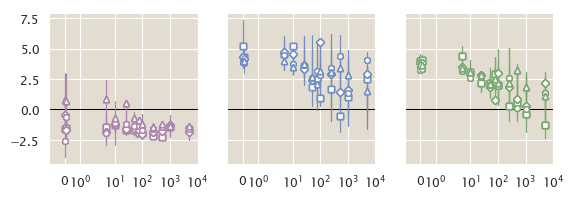

In [76]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(6.5, 2), dpi=100)
glyphs = {60:'s', 124:'D', 260:'o', 1220:'^'}
axes = {'Q21M':ax[0], 'Y20I': ax[1], 'Q21A':ax[2]}

for a in ax.ravel():
    a.xaxis.set_tick_params(labelsize=9)
    a.yaxis.set_tick_params(labelsize=9)
    a.set_xscale('symlog')
    a.hlines(0, -1, 1E4, lw=0.75)
    a.set_xlim([-1, 1E4])
    
for g, d in DNA.groupby(['mutant', 'repressors']):
    _ax = axes[g[0]]
    _ax.plot(d['IPTGuM'], d['delta_F_mode'], linestyle='none', marker=glyphs[g[1]],
            color=colors[g[0]], ms=4, markerfacecolor='w')
    _ax.vlines(d['IPTGuM'], d['delta_F_min'], d['delta_F_max'], lw=0.75, color=colors[g[0]])